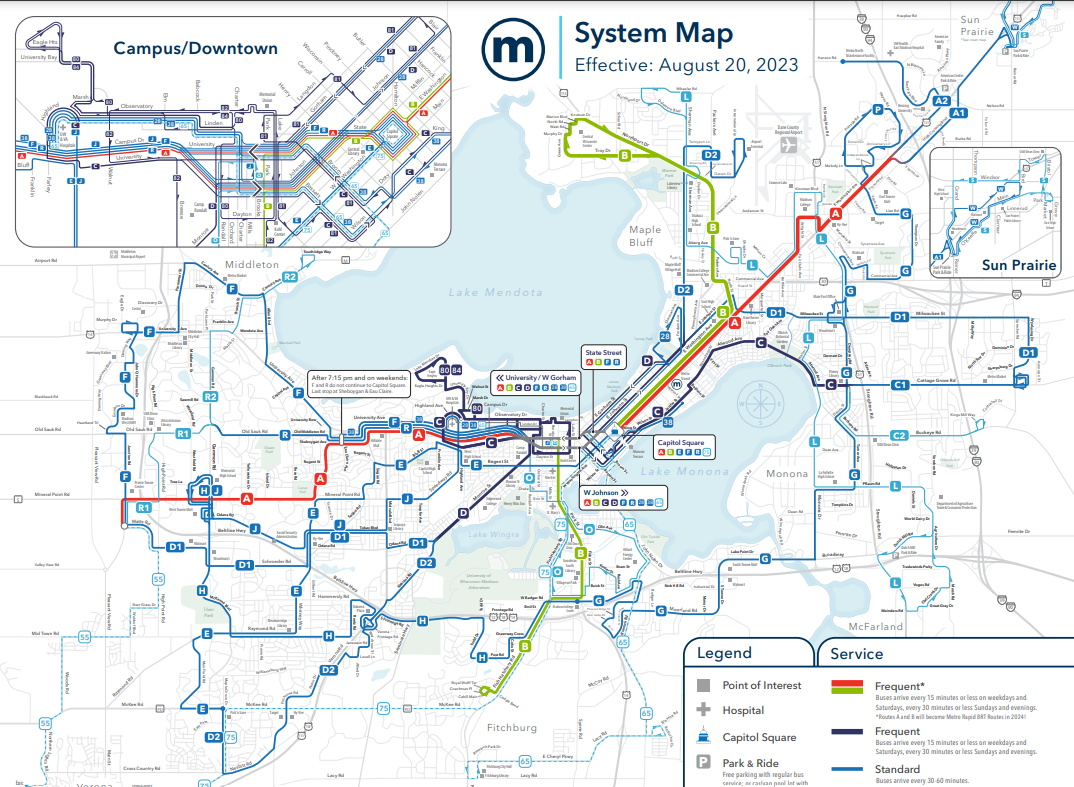

In [ ]:
# Warmup 0
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup

# New!
import sqlite3

In [ ]:
# Take a look at this HTML Table of Volunteer Hours

<table>
    <tr> <th>Name</th><th>Week 1</th><th>Week 2</th><th>Week 3</th> </tr>
    <tr> <td>Therese</td><td>13</td><td>4</td><td>5</td> </tr>
    <tr> <td>Carl</td><td>5</td><td>7</td><td>8</td> </tr>
    <tr> <td>Marie</td><td>2</td><td>9</td><td>11</td> </tr>
</table>

In [ ]:
# Warmup 1 : Parse this in Beautiful Soup

html = '''<table>
    <tr> <th>Name</th><th>Week 1</th><th>Week 2</th><th>Week 3</th> </tr>
    <tr> <td>Therese</td><td>13</td><td>4</td><td>5</td> </tr>
    <tr> <td>Carl</td><td>5</td><td>7</td><td>8</td> </tr>
    <tr> <td>Marie</td><td>2</td><td>9</td><td>11</td> </tr>
</table>'''

# set up a BeautifulSoup object
bs_obj = BeautifulSoup(html, 'html.parser')

# get the column names by finding all header elements
header_elements = bs_obj.find_all("th")
header = [e.get_text() for e in header_elements]
header

In [ ]:
# Warmup 2: Make a dictionary mapping name to total hours

# Get all row elements, but not the first one
row_elements = bs_obj.find_all("tr") [1:]
#print(row_elements)

# make an empty dict
hours_dict = {}

# iterate through the row_elements
for row in row_elements:
    # find all "td" elements in this row
    td_elements = row.find_all("td")
    #print(td_elements)
    
    # get the name and the 3 ints
    name = td_elements[header.index("Name")].get_text()
    week1 = td_elements[header.index("Week 1")].get_text()
    week2 = td_elements[header.index("Week 2")].get_text()
    week3 = td_elements[header.index("Week 3")].get_text()
    total = int(week1) + int(week2) + int(week3)
    #print(name, total)
    
    # add the dict entry
    hours_dict[name] = total
hours_dict


## Database 1

### Learning Objectives:

- Explain how a database is different from a CSV file or a JSON file
- Use SQLite to connect to a database and pandas to query the database
- Write basic queries on a database using SELECT, FROM, WHERE, ORDER BY, and LIMIT



To start, we will go over the slides to explain what Databases and SQL are


In [ ]:
# Get the Bus data from 'bus.db'

db_name = "bus.db"
assert os.path.exists(db_name)

# open a connection object to our database file
conn = sqlite3.connect(db_name)
# note: we need to close 'conn' when we are done, at the end of the notebook file
type(conn)


### Pandas has a function  `pd.read_sql(query, connection)`
- Allows us to process an SQL `query` on `connection`
- stores the result in a Pandas DataFrame

In [ ]:
# This command helps us know the table names 
df = pd.read_sql("""
    SELECT *
    FROM sqlite_master
    WHERE type='table'
""", conn)
df


### Databases are more structured than CSV and JSON files:
- all data contained inside one or more tables
- all tables must be named, all columns must be named 
- all values in a column must be the same type

In [ ]:
# This command shows how our database was set up (not part of CS220)
# Note the table names, we will use them later. Also note the column names
# Finally, note that types are more formal, different than Python, and strictly enforced

for command in df["sql"]:
    print(command)

### Most basic SQL query
Select Column(s) from Table

Can use * to mean "all columns"

In [ ]:
# pandas allows us to write a SQL query and create a DataFrame
pd.read_sql("select * from routes", conn)

In [ ]:
# repeat the step above but do this for stops
pd.read_sql("select * from stops", conn)

In [ ]:
# may repeat for trips and stop times, but we'll only look at the first 2 tables
pd.read_sql("select * from trips", conn)
pd.read_sql("select * from stop_times", conn)

In [ ]:
# look at more slides

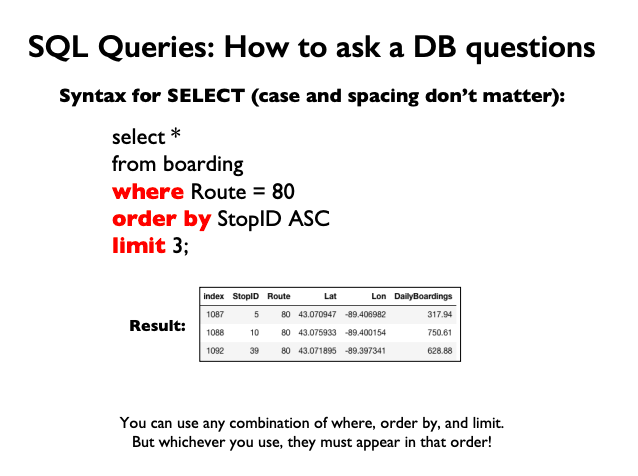

In [ ]:
# more complicated queries -- What question is this answering?
# Of the stops that are eastbound, what are the top 10 southern stops?

query = """
    SELECT *  
    FROM stops  
    WHERE cardinal_direction = 90
    ORDER BY stop_lat
    LIMIT 10
"""
pd.read_sql(query, conn)

In [ ]:
# Find the route service name for the "E" route
query = """
    select *
    from routes
    where route_short_name = 'E'
"""
pd.read_sql(query, conn).iloc[0]['route_service_name']

In [ ]:
# Find the stop name of the west-most bus stop

query = """
    select stop_name
    from stops
    order by stop_lon ASC
"""
pd.read_sql(query, conn).iloc[0]["stop_name"]

In [ ]:
# What are the names and descriptions of the westbound stops that are
# wheelchair-accessible and managed by the city of Sun Prarie (CSUN)?
# Order your answer by the name of the street
query = """
    select stop_name, stop_desc
    from stops
    where cardinal_direction = 270 and jurisdiction_id = 'CSUN' and wheelchair = 1
    order by primary_street ASC
"""
pd.read_sql(query, conn)

In [ ]:
# What is the URL I can go to to learn more about Route J?
# Bonus: According to the website, what are the directions that it takes?
#        (You can get this data from the 8th UL element)
query = """
    SELECT *
    FROM routes
    WHERE route_short_name = 'J'
"""
url = pd.read_sql(query, conn).iloc[0]["route_url"]
url

In [ ]:
r = requests.get(url)
bus_data = r.text
bs_obj = BeautifulSoup(bus_data, 'html.parser')
bs_list = bs_obj.find_all("ul")[7]
[bs_list_item.get_text() for bs_list_item in bs_list.children]

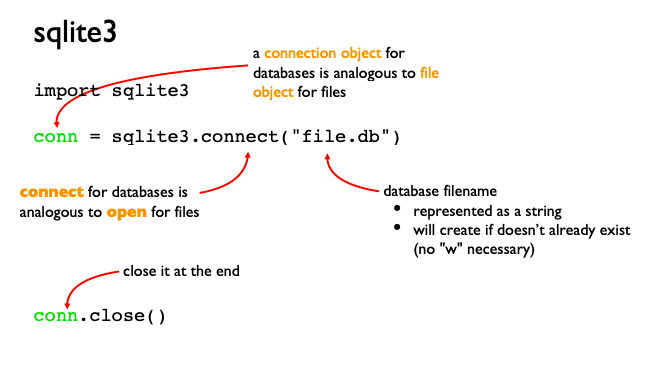

In [ ]:
# How many stops does the City of Fitchburg (CFIT) have jurisdiction over?
query = """
    select *
    from stops
    where jurisdiction_id = 'CFIT'
"""
len(pd.read_sql(query, conn))

In [ ]:
# How many stops does the City of Fitchburg (CFIT) have jurisdiction over?
query = """
    select COUNT(*) as TOTAL
    from stops
    where jurisdiction_id = 'CFIT'
""" # next time!
pd.read_sql(query, conn).iloc[0]['TOTAL']

In [ ]:
# Don't forget to close your connection!
conn.close()